In [11]:
#!pip install networkx
#!pip install --upgrade matplotlib
#!pip install scikit-learn scipy

In [12]:
import pandas as pd 
import re 
import string 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.corpus  
from nltk.text import Text  
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram, single,complete,average,weighted,centroid,median
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.cm as matcm
from networkx.algorithms import community
import math
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
ReyPosts = pd.read_csv('WheresRey.csv', encoding="ISO-8859-1")
# to display the first few rows
ReyPosts.head()

,Week,Posts,PostsInWeek
0,1,Target exclusively released a StarWars toy s...,4
1,1,Hasbro Why do you always leave the girl charac...,4
2,1,Oh look they even included some women IN THE B...,4
3,1,osakadaioh1 damn serious. Disney sexist market...,4
4,2,TheMarySue Who is missing from this picture? ...,314


Define a customized text processing function

In [14]:
def ReyPreprocessing(text): 
    # get lowercase
    text = text.lower()
    # remove numbers  

    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stop_words = stopwords.words('english')
    newStopWords = ['html','yet']
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    text = text.replace('theforceawakens', 'the force awakens')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('highlightsdearthfemaletoyhtml', 'highlights dearth female toy')
    text = text.replace('highlightsdearthinfemaletoyhtml', 'highlights dearth in female toy')
    text = text.replace('merchandise', 'merch')
    text = text.replace('merchs', 'merch')
    text = text.replace('merch', 'merchandise')
    text = text.replace('forceawakens', 'force awakens')
    text = text.replace('arewereallygoingtostart', 'are we really going to start')
    text = text.replace('makers', 'maker')
    text = text.replace('highlights', 'highlight')
    text = text.replace('thisway', 'this way')
    text = text.replace('figures', 'figure')
    text = text.replace('shes', 'she is')

    return text

#### Generate a Term Document Matrix

In [15]:
posts = ReyPosts.Posts.values
# preprocess posts
processed_posts = [ReyPreprocessing(text) for text in posts]
# Find frequent words and Generate word and frequency list
vectorizer = CountVectorizer(stop_words='english', lowercase = True) 
# Now X is the document-term matrix. 
x = vectorizer.fit_transform(processed_posts)
sum_words = x.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('whereisrey', 3351),
 ('starwars', 1352),
 ('rey', 1164),
 ('toy', 661),
 ('figure', 474),
 ('hasbro', 455),
 ('force', 409),
 ('female', 390),
 ('character', 383),
 ('disney', 376),
 ('set', 366),
 ('action', 366),
 ('main', 316),
 ('merchandise', 296),
 ('girl', 286),
 ('target', 273),
 ('awakens', 254),
 ('conversation', 199),
 ('sexism', 157),
 ('view', 150)]

### Topic Modeling via Social Network Analysis of Terms
To contruct the SNA of terms, we need to generate the adjacency matrix used as inout for SNA. We can use the generated Document-Term Matrix and produce the correlation matrix.

In [16]:
ReyDTM = pd.DataFrame(x.toarray().transpose(), index = vectorizer.get_feature_names_out() )
# removeSparseTerms, to remove 95% of sparse, here we keep terms that appear on at lest 5% of ducuments
ReyDTM = ReyDTM[ReyDTM.sum(axis=1) >= math.floor(0.05*ReyDTM.shape[1])]
ReyCorr = ReyDTM.transpose().corr(method ='pearson')
ReyCorr.iloc[:6,:6]

,action,awakens,black,character,characters,conversation
action,1.000000,0.030764,-0.031341,0.045754,0.039637,-0.058262
awakens,0.030764,1.000000,-0.046602,0.027834,-0.016152,-0.077788
black,-0.031341,-0.046602,1.000000,0.225497,-0.039371,-0.046198
character,0.045754,0.027834,0.225497,1.000000,-0.037401,-0.072566
characters,0.039637,-0.016152,-0.039371,-0.037401,1.000000,-0.027190
conversation,-0.058262,-0.077788,-0.046198,-0.072566,-0.027190,1.000000


We can see from the matrix that some of the correlation values are negative. This is not allowed in SNA as adjacency matrix may not be negative. We can set all negative values in the matrix to be 0

In [17]:
ReyCorr[ReyCorr<0]=0
ReyCorr.iloc[:6,:6]

,action,awakens,black,character,characters,conversation
action,1.000000,0.030764,0.000000,0.045754,0.039637,0.0
awakens,0.030764,1.000000,0.000000,0.027834,0.000000,0.0
black,0.000000,0.000000,1.000000,0.225497,0.000000,0.0
character,0.045754,0.027834,0.225497,1.000000,0.000000,0.0
characters,0.039637,0.000000,0.000000,0.000000,1.000000,0.0
conversation,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


We can then create the graph data object used for SNA visualization and analysis.

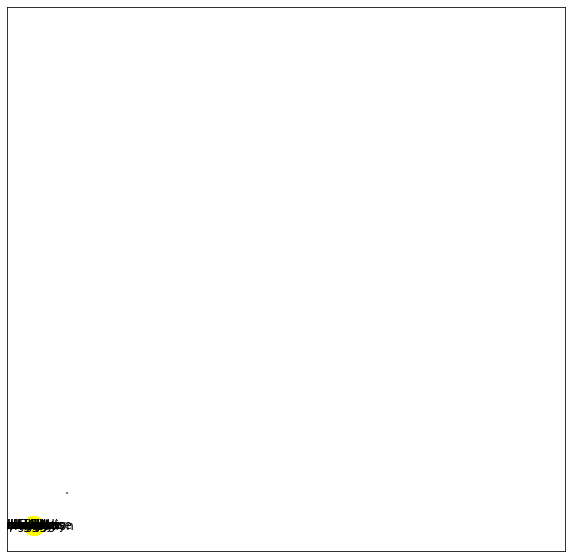

In [21]:
terms = ReyCorr.index.tolist()
labeldict = {}
for i in range(len(terms)):
    labeldict[i] = terms[i]

G = nx.from_numpy_matrix(np.array(ReyCorr))
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, labels=labeldict, with_labels=True, edge_color="gray", node_color = 'yellow')
plt.show()

In [22]:
Egen = nx.eigenvector_centrality(G)
VectorRey = []
for key in labeldict.keys():
    VectorRey.append([labeldict[key], Egen[key]])
    
VectorRey = pd.DataFrame(VectorRey)
VectorRey.columns = ['Node', 'Eigenvector_Centrality_Scores']
VectorRey = VectorRey.sort_values(by=['Eigenvector_Centrality_Scores'], ascending = False)
VectorRey.head(10)

,Node,Eigenvector_Centrality_Scores
30,whereisrey,0.304789
25,starwars,0.260067
3,character,0.251935
16,main,0.250179
27,toy,0.234345
21,rey,0.223549
1,awakens,0.222612
0,action,0.196754
18,missing,0.196737
8,female,0.195668


In [23]:
# generate the communities
communities_generator = community.greedy_modularity_communities(G)
communities_generator

[frozenset({0, 4, 9, 10, 11, 12, 14, 20, 22, 26, 29, 30}),
 frozenset({6, 7, 8, 13, 15, 17, 19, 24, 25, 27}),
 frozenset({1, 2, 3, 16, 18, 21, 23, 31}),
 frozenset({5, 28})]

In [24]:
# assign group ids to the nodes in each community
groups = {}
for i in range(len(communities_generator)):
    for j in sorted(communities_generator[i]):
        groups.update({j: i})
        
# sort the previous dictionary based on the sequence of the original nodes
sorted_group = {}
for n in G.nodes:
    sorted_group.update({n: groups[n]})

C:\Users\13193\AppData\Local\Temp/ipykernel_22252/176927262.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matcm.get_cmap('tab20', max(sorted_group.values()) + 1)


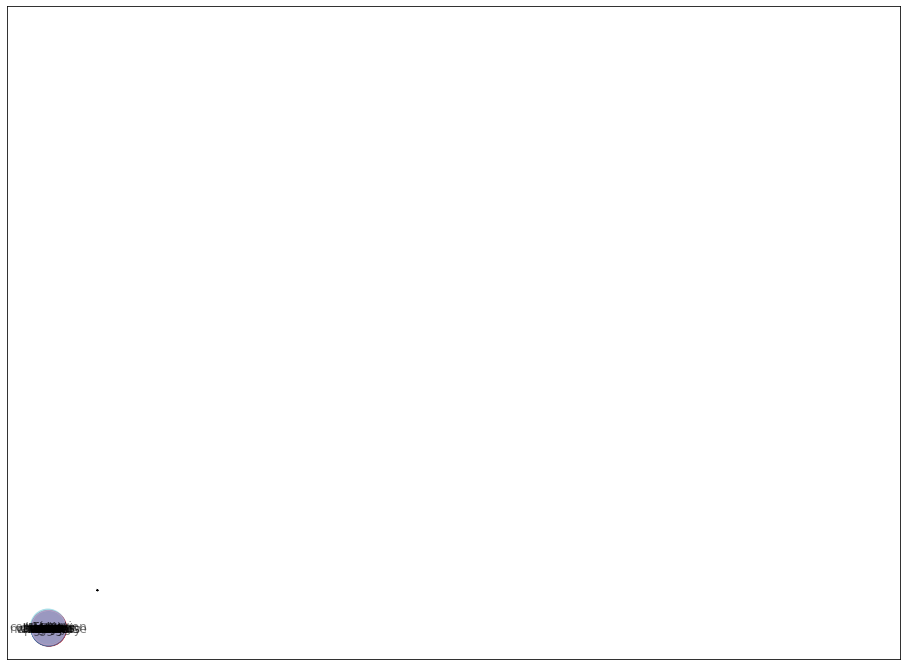

In [25]:
# fixing the size of the figure 
plt.figure(figsize = (16, 12))

# color the nodes according to their partition
cmap = matcm.get_cmap('tab20', max(sorted_group.values()) + 1)

# draw the network
pos = nx.spring_layout(G) 
nx.draw_networkx(G, node_color = list(sorted_group.values()), labels=labeldict, with_labels = True, cmap = cmap, 
                 font_size = 12, alpha=0.5, node_size = 1200, font_color = "k", pos=pos)

plt.show()

### Surfacing Aadhaar Topics

In [26]:
# import the data
aadhar = pd.read_csv('Aadhaar.csv', encoding="ISO-8859-1")
# to display the first few rows
aadhar.head()

,Text,Source
0,- <U+0A9C><U+0ABE><U+0AA3><U+0ACB> <U+0AA4><U+...,C
1,""" #Aadhaar card projects over Rs.13,663 crore ...",C
2,""" AADHAR is Voluntary""<ed><U+00A0><U+00BE><ed>...",C
3,""" The Earla Riopel News "" Daily ~ https://t.co...",C
4,""" The Earla Riopel News "" Daily ~ https://t.co...",C


Define a customized text processing function

In [27]:
def aPreprocessing(text): 
    # get lowercase
    text = text.lower()
    # remove numbers  

    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stop_words = stopwords.words('english')
    newStopWords = ['html','yet']
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    text = text.replace('amp', '')
    text = text.replace('aadhar', 'aadhaar')
    text = text.replace('aadhhar', 'aadhhar')
    text = text.replace('addhar', 'aadhaar')
    text = text.replace('adhar', 'aadhaar')
    text = text.replace('asdhar', 'aadhaar')
    text = text.replace('adhaar', 'aadhaar')
    text = text.replace('deccan chronicle', 'deccanchronicle')
    text = text.replace('indian express', 'indianexpress')
    text = text.replace('accusation', 'accuse')
    text = text.replace('accusations', 'accuse')
    text = text.replace('accused', 'accuse')
    text = text.replace('accuses', 'accuse')
    text = text.replace('accusing', 'accuse')
    text = text.replace('pls', 'please')
    # stemming
    stemmer= PorterStemmer()
    tokens = word_tokenize(text)
    words = [stemmer.stem(w) for w in tokens]
    result = " ".join(w for w in words)

    return result

Getting the text data into the DTM format

In [28]:
posts = aadhar.Text.values
# preprocess posts
processed_posts = [aPreprocessing(text) for text in posts]
# Find frequent words and Generate word and frequency list
vectorizer = CountVectorizer(stop_words='english', lowercase = True) 
x = vectorizer.fit_transform(processed_posts)
ADTM = pd.DataFrame(x.toarray().transpose(), index = vectorizer.get_feature_names_out() )
# removeSparseTerms, to remove 95% of sparse, here we keep terms that appear on at lest 5% of ducuments
ADTM = ADTM[ADTM.sum(axis=1) >= math.floor(0.05*ADTM.shape[1])]

Produce the adjacency matrix.

In [30]:
Acorr = ADTM.transpose().corr(method ='pearson')
Acorr[Acorr<0]=0

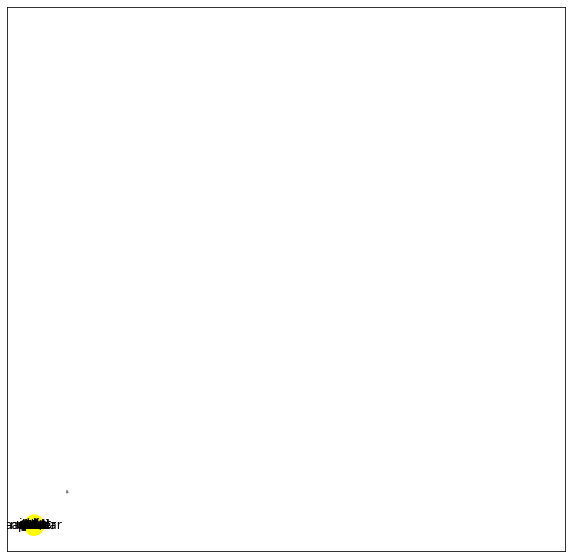

In [31]:
terms = Acorr.index.tolist()
labeldict = {}
for i in range(len(terms)):
    labeldict[i] = terms[i]

G = nx.from_numpy_matrix(np.array(Acorr),create_using=nx.MultiGraph)
plt.figure(figsize=(10,10))
nx.spring_layout(G)
nx.draw_networkx(G, labels=labeldict, with_labels=True, edge_color="gray", node_color = 'yellow')